In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle
import matplotlib.pyplot as plt
import random

In [ ]:
file_path = "expanded_organic_medicine_dataset.csv"  # Upload this file in Colab environment
df = pd.read_csv(file_path)
print("Dataset Loaded.\nSample:")
print(df.head())


Dataset Loaded.
Sample:
                                      symptoms        medicine
0                     itching, diarrhea, cough    Neem Tablets
1  vomiting, insomnia, joint pain, sore throat    Neem Tablets
2                        joint pain, dizziness  Peppermint Oil
3                           depression, stress    Amla Tablets
4  itching, joint pain, sore throat, skin rash  Moringa Powder


In [ ]:
def synonym_replacement(text, synonym_dict):
    words = text.split(', ')
    new_texts = []
    for _ in range(2):  # Generate two augmented versions
        new_words = [random.choice(synonym_dict.get(word.strip(), [word.strip()])) for word in words]
        new_texts.append(', '.join(new_words))
    return new_texts

In [ ]:
synonym_dict = {
    "fever": ["high temperature", "feverish"],
    "cough": ["dry cough", "persistent cough"],
    "sore throat": ["throat pain", "throat irritation"],
    "headache": ["migraine", "head pain"],
    "nausea": ["queasiness", "sick feeling"],
    "anxiety": ["nervousness", "worry"],
    "stress": ["tension", "pressure"]
}


In [ ]:
augmented_rows = []
for idx, row in df.iterrows():
    new_symptoms = synonym_replacement(row['symptoms'], synonym_dict)
    for new_symptom in new_symptoms:
        augmented_rows.append({"symptoms": new_symptom, "medicine": row['medicine']})

aug_df = pd.DataFrame(augmented_rows)
df = pd.concat([df, aug_df], ignore_index=True)
print("\nData augmented. Total records:", len(df))


Data augmented. Total records: 3000


In [ ]:
symptom_tokenizer = Tokenizer(oov_token="<OOV>")
symptom_tokenizer.fit_on_texts(df['symptoms'])
X = symptom_tokenizer.texts_to_sequences(df['symptoms'])
X = pad_sequences(X, padding='post')

In [ ]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['medicine'])
num_classes = len(np.unique(y))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = Sequential([
    Embedding(input_dim=len(symptom_tokenizer.word_index) + 1, output_dim=64, input_length=X.shape[1]),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
history = model.fit(X_train, y_train, epochs=15, batch_size=4, validation_data=(X_test, y_test))

Epoch 1/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - accuracy: 0.0712 - loss: 2.7073 - val_accuracy: 0.0667 - val_loss: 2.6970
Epoch 2/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.0851 - loss: 2.6925 - val_accuracy: 0.0717 - val_loss: 2.6907
Epoch 3/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.0923 - loss: 2.6767 - val_accuracy: 0.0733 - val_loss: 2.7043
Epoch 4/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.1087 - loss: 2.6623 - val_accuracy: 0.1000 - val_loss: 2.6798
Epoch 5/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.1106 - loss: 2.6395 - val_accuracy: 0.0983 - val_loss: 2.6753
Epoch 6/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.1664 - loss: 2.5480 - val_accuracy: 0.1300 - val_loss: 2.6388
Epoch 7/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.1722 - loss: 2.5252 - val_accuracy: 0.1350 - val_loss: 2.6154
Epoch 8/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.1875 - loss: 2.4813 - val_

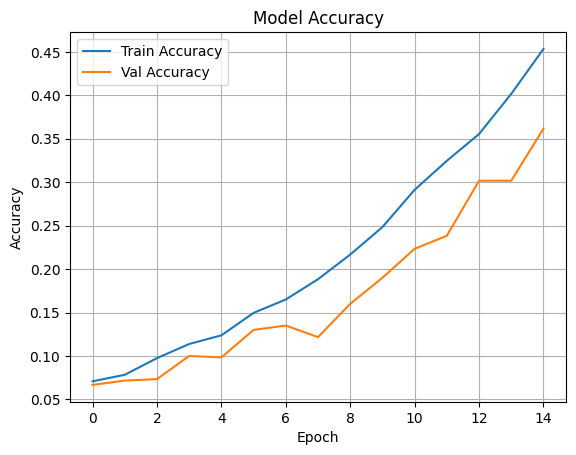

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.save("organic_medicine_model.h5")
with open("symptom_tokenizer.pkl", "wb") as f:
    pickle.dump(symptom_tokenizer, f)
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

print("Model and preprocessing objects saved.")

Model and preprocessing objects saved.


In [ ]:
def predict_medicines(symptom_text, top_k=5):
    with open("symptom_tokenizer.pkl", "rb") as f:
        tokenizer = pickle.load(f)
    with open("label_encoder.pkl", "rb") as f:
        label_encoder = pickle.load(f)
    model = load_model("organic_medicine_model.h5")

    sequence = tokenizer.texts_to_sequences([symptom_text])
    padded = pad_sequences(sequence, maxlen=X.shape[1], padding='post')
    prediction = model.predict(padded)[0]
    top_indices = prediction.argsort()[-top_k:][::-1]
    recommended_medicines = label_encoder.inverse_transform(top_indices)
    return recommended_medicines

In [ ]:
user_input = input("Enter symptoms separated by commas (e.g., headache, nausea): ")
recommendations = predict_medicines(user_input)
print(f"\nInput Symptoms: {user_input}\nRecommended Organic Medicines: {', '.join(recommendations)}")

Enter symptoms separated by commas (e.g., headache, nausea): body pain,sneezing,cold,cough


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step

Input Symptoms: body pain,sneezing,cold,cough
Recommended Organic Medicines: Chamomile Tea, Peppermint Oil, Turmeric Capsules, Arjuna Bark, Amla Tablets
